# The Best Neighborhood in Pittsburgh Presentation
**Simon Schueller (sps67)**  
**Eric Anderson (ema85)**  
**Justin Reagle (jmr278)**  

# Data Sets
* police_arrest_data
* playground_equipment
* housing_prices

# Metrics and Calculations

## Police arrest data
Analyzing [police_arrest_data](https://data.wprdc.org/dataset/arrest-data) from the WPRDC to determine the best neighborhood in Pittsburgh.

#### Abstract
As you can see from the first few cells of data, there are unique codes to identify specific offenses that led to arrests. These offense types will be used to calculate a score for each neighborhood in Pittsburgh. Each offense listed for an arrest will automatically count for +1 but some specific offenses will count for more than +1. These scores for each arrest in a neighborhood will then be summed and normalized to a value between 0 and 1. The neighborhood with the lowest overall score is deemed most desireable to live. This neighborhood will be the place with a small amount of crimes, which are not **personal** or **property** crimes.

#### Special Offenses
Source: [Categories of Crimes](https://www.justia.com/criminal/offenses/)  

**Personal Crimes** and **Property Crimes** are treated as special cases and bear more weight on determining score, since they are to be avoided at all costs.  

"Personal crimes are those that result in physical or mental harm to another person." [Justia](https://www.justia.com/criminal/offenses/)   
"Property crimes typically involve interference with the property of another." [Justia](https://www.justia.com/criminal/offenses/)

* Retail Theft +2
* Aggravated Assault +4
* Recklessly Endangering Another Person +2
* Endangering Welfare of Children +3
* Simple Assault +3
* Intentionally Damages Real Or Personal Property Of Another +2
* Robbery +3
* Burglary +3
* Theft by Unlawful Taking or Disposition +2
* Harassment by Physical Contact, or Attempts or Threats +3
* Robbery of Motor Vehicle +3
* Criminal Homicide +10
* Kidnapping +7
* Reckless Driving +2
* Rape +5
* Sexual Assault +3
* Indecent Assault +3
* Aggravated Indecent Assault +3
* Involuntary Manslaughter +5
* Homicide by Vehicle +10
* Homicide by Vehicle While Driving Under the Influence +10
* Strangulation +5

#### Police arrests data

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

arrests = pd.read_csv("https://data.wprdc.org/datastore/dump/e03a89dd-134a-4ee8-a2bd-62c40aeebc6f")
# Import RegEx for Python
import re

# Arrays of codes based on special point values
plus_2 = [3929, 2705, 3304, 3921, 3736]
plus_3 = [4304, 2701, 3701, 3502, 2709, 3702, 3124, 3126]
plus_4 = [2702]
plus_5 = [3121, 2504, 2718]
plus_7 = [2901]
plus_10 = [2501, 3732, 3735]

# Function to calculate scores based on codes
def get_value(code):
    if code in plus_2:
        return 2
    elif code in plus_3:
        return 3
    elif code in plus_4:
        return 4
    elif code in plus_5:
        return 5
    elif code in plus_7:
        return 7
    elif code in plus_10:
        return 10
    else:
        return 1


scores = {}

# Get each row from arrests
for arrest in arrests.index:
    
    # Make sure a valid entry is made in each column
    if isinstance(arrests['INCIDENTNEIGHBORHOOD'][arrest], str) and isinstance(arrests["OFFENSES"][arrest], str):
        
        neighborhood = arrests['INCIDENTNEIGHBORHOOD'][arrest]
        offences_str = arrests["OFFENSES"][arrest]
        
        # Make array of individual offences
        offences = [offence.strip() for offence in offences_str.split('/')]
        for offence in offences:
            
            # Get offence code by regex
            offence_code = re.search(r'\d+', offence)
            if offence_code != None:
                offence_code = int(offence_code.group())
            
            # Get point value for that code
            points = get_value(offence_code)
            
            # Filter out bad input
            if neighborhood[:3] != "Mt." and "-Herrs" not in neighborhood:
                
                # Add to scores dictionary
                if neighborhood in scores:
                    scores[neighborhood] += points
                else:
                    scores[neighborhood] = points
                    
# Sort dictionary of scores                    
sorted_scores = sorted(scores.items(), key=lambda x: x[1])
                    
# Normalize the score
max_score = max(scores.values())
for score in scores:
    scores[score] /= max_score
    scores[score] = round(scores[score], 3)

#### Visualization

<ipython-input-3-0020f4ef28f2>:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  scores_map["center"] = scores_map["geometry"].centroid


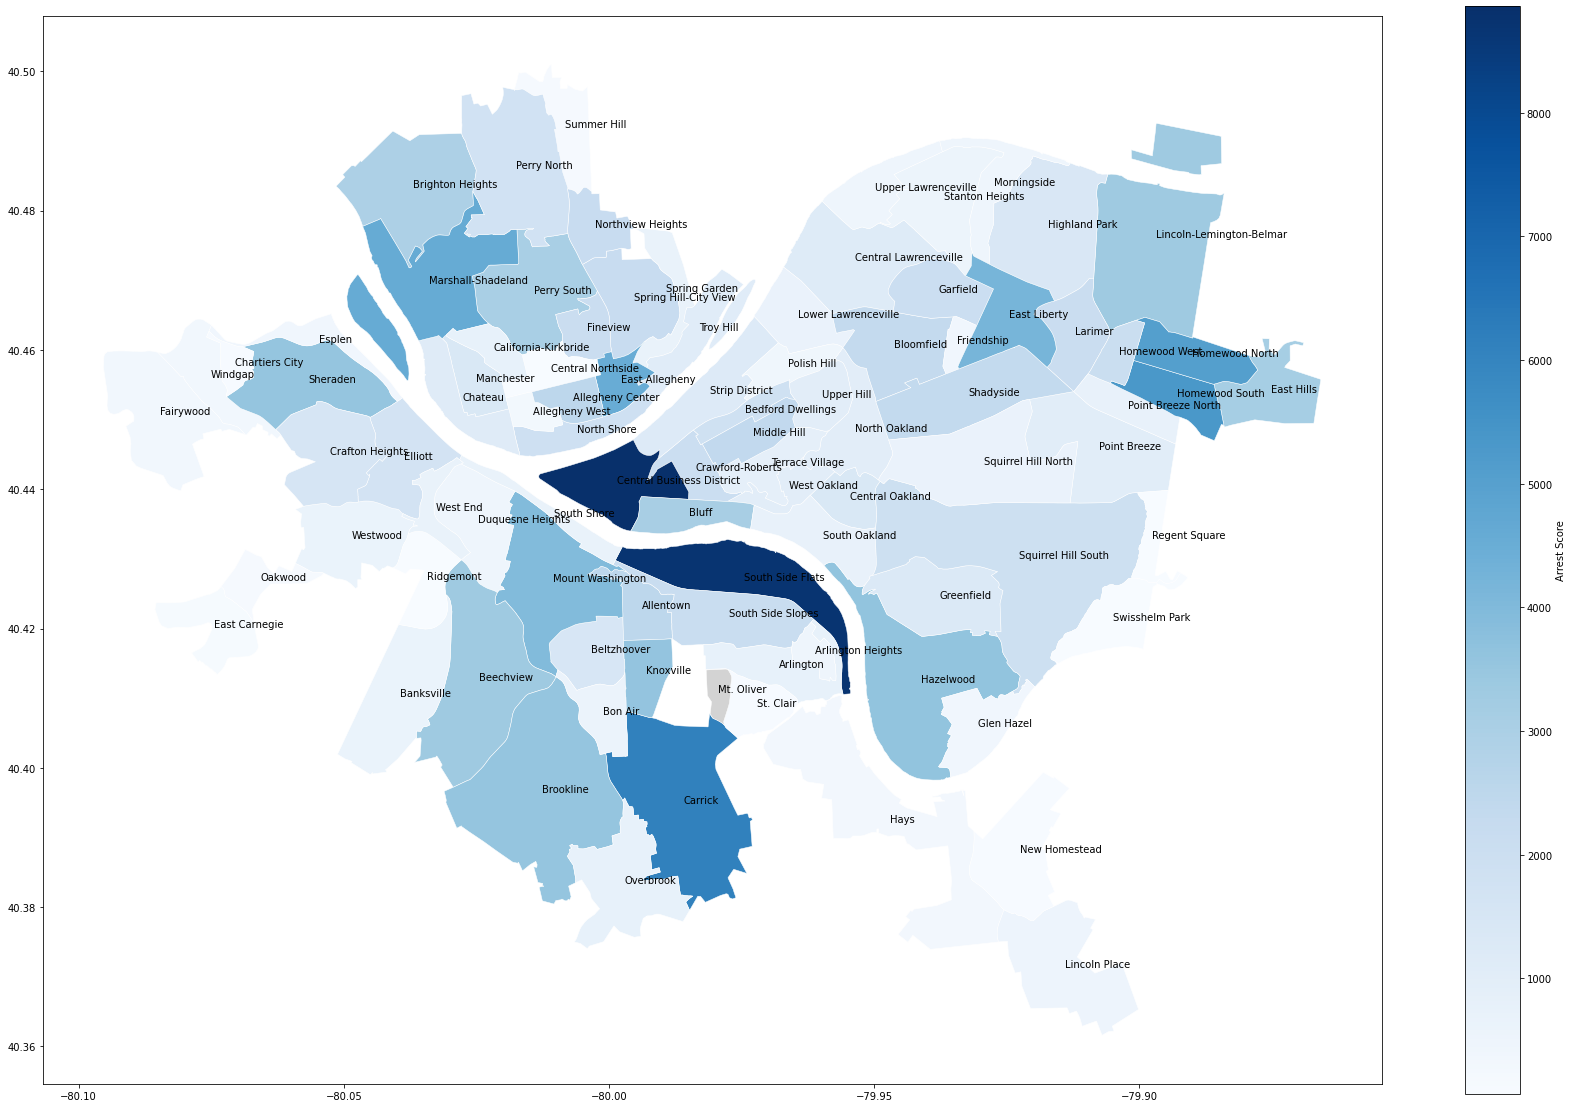

In [3]:
import geopandas

# Read in file with geographical data of Pittsburgh Neighborhoods
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp") # read in the shapefile

# Create dataframe from scores
df_scores = pd.DataFrame.from_dict(sorted_scores)

# Merge with map dataframe
scores_map = neighborhoods.merge(df_scores, how='left', left_on='hood', right_on=0)

# Setup for labels on data regions
scores_map["center"] = scores_map["geometry"].centroid
scores_map_points = scores_map.copy()
scores_map_points.set_geometry("center", inplace = True)

ax = scores_map.plot(column=1,
                     cmap='Blues',
                     legend=True,
                     legend_kwds={'label': "Arrest Score"},
                     figsize = (30, 20),
                     missing_kwds={"color": "lightgrey"}, 
                     edgecolor = "white",
                     linewidth = 0.5)
texts = []

# Create the labels
for x, y, label in zip(scores_map_points.geometry.x, scores_map_points.geometry.y, scores_map_points["hood"]):
    texts.append(plt.text(x, y, label, fontsize = 10))

## Playground Data

#### Abstract
*Edit Me


#### Playground Data

In [4]:
#Playground Data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

playground_equipment = pd.read_csv("playground_data.csv")
playground_equipment.head()

grouped_equipment = playground_equipment.groupby('neighborhood')

# creating the dictionary with every neighborhood in the dataset and assigning it a score of 0 to start
playground_scores = dict()
for neighborhood in playground_equipment.neighborhood.unique():
    playground_scores[neighborhood] = 0

# setting up the constants
num_playgrounds_weight = 2  
ada_accessible_weight = 4
quality_weight = 10

# adding the score for number of unique equipment pieces (quality)
for i in range(grouped_equipment.equipment_type.nunique().count()):
    playground_scores[grouped_equipment.equipment_type.nunique().index[i]] += grouped_equipment.equipment_type.nunique()[i]

# adding the score for the number of ADA accessible equipment pieces
for i in range(grouped_equipment.ada_accessible.value_counts().count()):
    if grouped_equipment.ada_accessible.value_counts().index[i][1] == "t":
        playground_scores[grouped_equipment.ada_accessible.value_counts().index[i][0]] += grouped_equipment.ada_accessible.value_counts()[i] * ada_accessible_weight

# weight the quality score
for neighborhood in playground_scores:
    playground_scores[neighborhood] *= quality_weight
        
# adding the score for number of pieces of equipment (quantity)
for i in range(grouped_equipment.id.count().count()):
    playground_scores[grouped_equipment.id.count().index[i]] += grouped_equipment.id.count()[i]

# adding the score for number of playgrounds (quantity)
for i in range(grouped_equipment.name.nunique().count()):
    playground_scores[grouped_equipment.name.nunique().index[i]] += grouped_equipment.name.nunique()[i] * num_playgrounds_weight

# normalizing the score to a (0, 1) range
max_score = max(playground_scores.values())
for neighborhood in playground_scores:
    playground_scores[neighborhood] /= max_score
    playground_scores[neighborhood] = round(playground_scores[neighborhood], 3)

#### Visualization

*ADD FOR PLAYGROUNDS

## Housing Cost Data

#### Abstract
*Edit Me


#### Housing Cost Data

In [13]:
house_data = pd.read_csv("https://data.wprdc.org/dataset/5b18c198-474c-4723-b735-cc5220ad43cc/resource/13982f58-e618-400c-8f69-6a32dbd7c68f/download/value.csv")

total = []
neighborhood = [] # added 
for y in range(0, len(house_data.index)):
    add = 0
    for x in house_data.iloc[y, [30,32,34,36,38,40]]:
        add = add + x
    total.append(add)
    neighborhood.append(house_data.iloc[y, 0]) # add titles

temp_dict = {"Neighborhoods": neighborhood, "Total": total} # dictionary with titles
houses = pd.DataFrame(temp_dict) # pass in dict

# for x in range(0, len(total)):
#     houses.rename(index = {x: data.iloc[x, [0]]})

percentage = []
for x in range(0, len(total)):
    if house_data.iloc[x,2] == 0:
        math = 0;  #For the neighboorhoods that had 0 houses in survey
    else:
        math = total[x]/ house_data.iloc[x, 2]
    percentage.append(math)
    
house_per = pd.DataFrame(percentage)

#### Visualization
*ADD FOR HOUSING DATA

# Combining the Data

In [9]:
final_scores = dict()

playground_weighting = 1
arrest_weighting = 1
house_weighting = 1

#adding scores for playgrounds
for neighborhood in playground_scores:
    final_scores[neighborhood] = playground_scores[neighborhood] * playground_weighting

#adding scores for arrests
for neighborhood in scores:
    if neighborhood in final_scores:
        final_scores[neighborhood] = final_scores[neighborhood] + (1 - scores[neighborhood]) * arrest_weighting
    else:
        final_scores[neighborhood] = (1 - scores[neighborhood]) * arrest_weighting
        
#adding scores for house prices
for i in range(len(house_data.index)):
    neighborhood = house_data.iloc[i, 0]
    if neighborhood in final_scores:
        final_scores[neighborhood] = final_scores[neighborhood] + house_per.iloc[i, 0] * house_weighting
    else:
        final_scores[neighborhood] = house_per.iloc[i, 0] * house_weighting
        
#sorting total
final_sorted = sorted(final_scores.items(), key=lambda x: x[1], reverse=True)
for i in range(len(final_scores)):
    print(str(i + 1) + ". " + final_sorted[i][0] + " - " + str(final_sorted[i][1]))

1. Squirrel Hill South - 2.2676269035532997
2. Allegheny Center - 2.0780000000000003
3. Swisshelm Park - 1.9058249027237355
4. Friendship - 1.867392405063291
5. Regent Square - 1.8295830903790087
6. Greenfield - 1.8283547094188377
7. New Homestead - 1.7910371352785146
8. Morningside - 1.7774109014675052
9. Banksville - 1.7640913705583756
10. Point Breeze North - 1.7486190476190477
11. Highland Park - 1.721510752688172
12. Central Northside - 1.695920517560074
13. Stanton Heights - 1.667775486152033
14. Oakwood - 1.6323389830508475
15. Lower Lawrenceville - 1.5905404814004376
16. Bloomfield - 1.5841042654028437
17. Central Lawrenceville - 1.5807093596059114
18. South Side Slopes - 1.578937321937322
19. Crawford-Roberts - 1.556424778761062
20. Central Oakland - 1.5562124352331606
21. Polish Hill - 1.5401916167664669
22. South Oakland - 1.4963062200956938
23. Duquesne Heights - 1.4892281959378733
24. Westwood - 1.4815416238437822
25. Beechview - 1.476685230024213
26. Windgap - 1.472746741

# Visualization

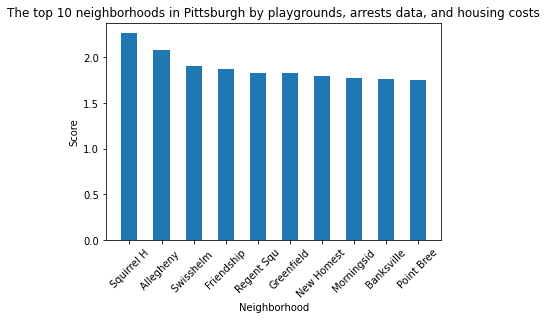

In [10]:
# Data Plot of top 10 Scoring neighborhoods
arr_scores = []
neighborhoods = []
for i in range(10):
    neighborhoods.append(final_sorted[i][0][0:10])
    arr_scores.append(final_sorted[i][1])

plt.bar(neighborhoods, arr_scores, width=0.5)
plt.title("The top 10 neighborhoods in Pittsburgh by playgrounds, arrests data, and housing costs")
plt.xlabel("Neighborhood")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()

In [12]:
# Read in file with geographical data of Pittsburgh Neighborhoods
neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp") # read in the shapefile

# Create dataframe from scores
df_scores = pd.DataFrame.from_dict(final_sorted)

# Merge with map dataframe
scores_map = neighborhoods.merge(df_scores, how='left', left_on='hood', right_on=0)

# Setup for labels on data regions
scores_map["center"] = scores_map["geometry"].centroid
scores_map_points = scores_map.copy()
scores_map_points.set_geometry("center", inplace = True)

ax = scores_map.plot(column=1,
                     cmap='Blues',
                     legend=True,
                     legend_kwds={'label': "Overall Score"},
                     figsize = (30, 20),
                     missing_kwds={"color": "lightgrey"}, 
                     edgecolor = "white",
                     linewidth = 0.5)
texts = []

# Create the labels
for x, y, label in zip(scores_map_points.geometry.x, scores_map_points.geometry.y, scores_map_points["hood"]):
    texts.append(plt.text(x, y, label, fontsize = 10))

<ipython-input-12-3fa8a8fc6b48>:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  scores_map["center"] = scores_map["geometry"].centroid
/opt/tljh/user/lib/python3.8/site-packages/geopandas/plotting.py:373: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


ValueError: cannot convert float NaN to integer

ValueError: cannot convert float NaN to integer

# Conclusions

## Simon
*Conclusion

## Eric
*Conclusion

## Justin
*Conclusion

# Overall Best Neighborhood is...

![DrumRollGIF](https://media.giphy.com/media/FP56vNcwOVyvu/giphy.gif)

### INSERT_BEST_NEIGHBORHOOD 🎉 🎊 🎈 